# SAEval

In [4]:
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt

### TEST

In [1]:
from circuit import IOICircuit
from sae_lens import HookedSAETransformer
import json 

with open('tasks/ioi/cfg.json') as f:
    cfg = json.load(f)

with open('tasks/ioi/prompts.json') as f:
    prompts = json.load(f)

with open('tasks/ioi/names.json') as f:
    names = json.load(f)

print(f"N. prompts: {len(prompts)}")

model: HookedSAETransformer = HookedSAETransformer.from_pretrained_no_processing("gpt2").to('cuda')
model.eval()

ioi_circuit = IOICircuit(
    model=model,
    cfg=cfg,
    prompts=prompts,
    names=names)

#ioi_circuit.load_saes('z')
#ioi_circuit.load_saes('resid_pre')

#ioi_circuit.compute_supervised_dictionary()

/workspace/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


N. prompts: 20000
Loaded pretrained model gpt2 into HookedTransformer
Moving model to device:  cuda


In [ ]:
ioi_circuit.load_saes('resid_pre')

100%|██████████| 11/11 [00:23<00:00,  2.14s/it]


In [ ]:
{"model_name": "gpt2-small", "hook_point": "blocks.0.hook_resid_pre", "hook_point_layer": 0, "hook_point_head_index": null, "dataset_path": "Skylion007/openwebtext", "is_dataset_tokenized": false, "context_size": 128, "use_cached_activations": false, "cached_activations_path": "activations/Skylion007_openwebtext/gpt2-small/blocks.0.hook_resid_pre", "d_in": 768, "n_batches_in_buffer": 128, "total_training_tokens": 300000000, "store_batch_size": 32, "device": "mps", "seed": 42, "dtype": "torch.float32", "b_dec_init_method": "geometric_median", "expansion_factor": 32, "from_pretrained_path": null, "l1_coefficient": 8e-05, "lr": 0.0004, "lr_scheduler_name": null, "lr_warm_up_steps": 5000, "train_batch_size": 4096, "use_ghost_grads": false, "feature_sampling_window": 1000, "feature_sampling_method": null, "resample_batches": 1028, "feature_reinit_scale": 0.2, "dead_feature_window": 5000, "dead_feature_estimation_method": "no_fire", "dead_feature_threshold": 1e-08, "log_to_wandb": true, "wandb_project": "mats_sae_training_gpt2_small_resid_pre_5", "wandb_entity": null, "wandb_log_frequency": 100, "n_checkpoints": 10, "checkpoint_path": "checkpoints/y1t51byy", "d_sae": 24576, "tokens_per_buffer": 67108864, "run_name": "24576-L1-8e-05-LR-0.0004-Tokens-3.000e+08"}

In [103]:
torch.load('tmp/activations.pt')['k']['IO'].shape

torch.Size([12, 20000, 12, 64])

In [51]:
from circuit import IOIPrompt
import torch 

idx = 1

example = IOIPrompt(prompts[idx], id=idx)
example.tokenize(model)

In [52]:
io = example.get_variable('IO')
s = example.get_variable('S')

io_tok = model.to_single_token(io)
s_tok = model.to_single_token(s)

In [53]:
with torch.no_grad():
    logits, cache = model.run_with_cache(example.tokens)

logits = logits[:, -1]
best_toks = logits.argsort(descending=True, dim=-1)
print(f"Prompt: '{example.text}'")
print(f"First Best token: '{model.tokenizer.decode(best_toks[0, 0].item())}'")
print(f"Second Best token: '{model.tokenizer.decode(best_toks[0, 1].item())}'")
print(f"Logit difference between '{io}' and '{s}': {logits[0, io_tok] - logits[0, s_tok]}")

Prompt: 'Then, Ross and Adrian were working at the jersey. Adrian decided to give a guitar to'
First Best token: ' Ross'
Second Best token: ' the'
Logit difference between ' Ross' and ' Adrian': 4.470558166503906


In [108]:
cache

ActivationCache with keys ['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_mlp_out', 'blocks.1.hook_resid_post', 'blocks.2.hook_re

In [71]:
l = 8
z = cache[f'blocks.{l}.attn.hook_z'][0, -1] # [12, 64]
attn_out = cache[f'blocks.{l}.hook_attn_out'][0, -1] # [768]
W_O = model.W_O[l] # [12, 64, 768]
b_O = model.b_O[l] # [768]

((z[:, None] @ W_O).sum(0)[0] + b_O - attn_out).abs().max()

tensor(1.9073e-06, device='cuda:0', grad_fn=<MaxBackward1>)

In [73]:
model.b_K[0,0,None].shape

torch.Size([1, 64])

In [70]:
(z[:, None] @ W_O).sum(0).shape

torch.Size([1, 768])

In [69]:
attn_out.shape

torch.Size([768])

In [74]:
model.W_O[0].shape, model.b_O[l, None].shape

(torch.Size([12, 64, 768]), torch.Size([1, 768]))

In [7]:
def logits_diff(logits, correct_answer, incorrect_answer=None):
    correct_index = model.to_single_token(correct_answer)
    if incorrect_answer is None:
        return logits.cpu().numpy()[0, -1, correct_index]
    else:
        incorrect_index = model.to_single_token(incorrect_answer)
        #print(f"Correct token logit: {logits.cpu().numpy()[0, -1, correct_index]}")
        #print(f"Incorrect token logit: {logits.cpu().numpy()[0, -1, incorrect_index]}")
        return logits.cpu().numpy()[0, -1, correct_index] - logits.cpu().numpy()[0, -1, incorrect_index]

In [147]:
from circuit import IOIPrompt
import torch

all_nodes_labels = ['bNMH-q', 'bNMH-qk', 'IH+DTH-z', 'SIH-v', 'SIH-z', 'bNMH-z']
all_nodes = [['bNMH.q'], ['bNMH.qk'], ['IH.z', 'DTH.z'], ['SIH.v'], ['SIH.z'], ['bNMH.z']]

example = IOIPrompt(prompts[idx], id=idx)
example.tokenize(model)
io = example.get_variable('IO')
s = example.get_variable('S')

score_df = {
    'label': [],
    'method': [],
    'reconstruction': [],
    'diff': []
}

# Get clean logits
with torch.no_grad():
    clean_logits, clean_cache = ioi_circuit.model.run_with_cache(example.tokens)

clean_diff = logits_diff(clean_logits, io, s)
print(f"Clean: {clean_diff.item()}")

for node_names, node_label in zip(all_nodes, all_nodes_labels):
    print(f"\n{node_label}")

    ### SUPERVISED DICTIONARY - sufficency
    #patched_logits = ioi_circuit.run_with_reconstruction(
    #    example, 
    #    node_names=node_names,
    #    method='supervised',
    #    cache=clean_cache,
    #    reconstruction='sufficency',
    #    verbose=True
    #    )
#
    #print(f"\nSufficency - Supervised: {logits_diff(patched_logits, io, s).item()}")
    #score_df['label'].append(node_label)
    #score_df['method'].append('supervised')
    #score_df['reconstruction'].append('sufficency')
    #score_df['diff'].append(logits_diff(patched_logits, io, s).item())
#
    ### SAE FEATURES - sufficency
    patched_logits = ioi_circuit.run_with_reconstruction(
        example, 
        node_names=node_names,
        method='sae',
        cache=clean_cache,
        reconstruction='sufficency',
        verbose=True
        )

    print(f"Sufficency - SAE: {logits_diff(patched_logits, io, s).item()}")
    score_df['label'].append(node_label)
    score_df['method'].append('sae')
    score_df['reconstruction'].append('sufficency')
    score_df['diff'].append(logits_diff(patched_logits, io, s).item())

    ### SUPERVISED DICTIONARY - necessity
    #patched_logits = ioi_circuit.run_with_reconstruction(
    #    example, 
    #    node_names=node_names,
    #    method='supervised',
    #    cache=clean_cache,
    #    reconstruction='necessity',
    #    verbose=False
    #    )
#
    #print(f"Necessity - Supervised: {logits_diff(patched_logits, io, s).item()}")
    #score_df['label'].append(node_label)
    #score_df['method'].append('supervised')
    #score_df['reconstruction'].append('necessity')
    #score_df['diff'].append(logits_diff(patched_logits, io, s).item())

    ### SAE FEATURES - necessity
    patched_logits = ioi_circuit.run_with_reconstruction(
        example, 
        node_names=node_names,
        method='sae',
        cache=clean_cache,
        reconstruction='necessity',
        verbose=False
        )

    print(f"Necessity - SAE: {logits_diff(patched_logits, io, s).item()}")
    score_df['label'].append(node_label)
    score_df['method'].append('sae')
    score_df['reconstruction'].append('necessity')
    score_df['diff'].append(logits_diff(patched_logits, io, s).item())

    ### ABLATION
    patched_logits = ioi_circuit.run_with_reconstruction(
        example, 
        node_names=node_names,
        method='ablation',
        cache=clean_cache,
        reconstruction='necessity',
        verbose=False
        )

    print(f"Ablation: {logits_diff(patched_logits, io, s).item()}")
    score_df['label'].append(node_label)
    score_df['method'].append('ablation')
    score_df['reconstruction'].append('necessity')
    score_df['diff'].append(logits_diff(patched_logits, io, s).item())

df = pd.DataFrame(score_df)
df['diff_adj'] = df['diff'] - clean_diff

Clean: 4.470558166503906

bNMH-q
Prompt: Then, Ross and Adrian were working at the jersey. Adrian decided to give a guitar to
Caching activations...
Hooking L9H0 q (END) at position 18
Hooking L9H7 q (END) at position 18
Hooking L10H1 q (END) at position 18
Hooking L10H2 q (END) at position 18
Hooking L10H6 q (END) at position 18
Hooking L10H10 q (END) at position 18
Hooking L11H2 q (END) at position 18
Hooking L11H9 q (END) at position 18
Sufficency - SAE: -0.5435638427734375
Necessity - SAE: 4.5329437255859375
Ablation: 4.7259063720703125

bNMH-qk
Prompt: Then, Ross and Adrian were working at the jersey. Adrian decided to give a guitar to
Caching activations...
Hooking L9H0 q (END) at position 18
Hooking L9H7 q (END) at position 18
Hooking L10H1 q (END) at position 18
Hooking L10H2 q (END) at position 18
Hooking L10H6 q (END) at position 18
Hooking L10H10 q (END) at position 18
Hooking L11H2 q (END) at position 18
Hooking L11H9 q (END) at position 18
Hooking L9H0 k (IO) at position 3

In [39]:
clean_diff

3.109787

In [35]:
df

,label,method,reconstruction,diff,diff_adj
0,SIH-v,supervised,sufficency,10.439528,7.329741
1,SIH-v,sae,sufficency,-10.914150,-14.023937
2,SIH-v,supervised,necessity,-21.071777,-24.181564
3,SIH-v,sae,necessity,0.876213,-2.233574
4,SIH-v,ablation,necessity,0.296574,-2.813213


## STANDARD

### Sufficency / Necessity

In [38]:
dfs = [] 

path = 'tasks/ioi/sn-scores-standard/'

for file in os.listdir(path):
    if file.endswith('.json'):
        file_name = file.split('.')[0]
        data = pd.read_json(os.path.join(path, file))
        data['node'] = file_name
        dfs.append(data)

df = pd.concat(dfs, ignore_index=True)

In [39]:
sufficency_df = df[['node', 'clean_ld', 'sae_full_ld']].copy()
necessity_df = df[['node', 'clean_ld', 'sae_average_ld', 'ablation_ld']].copy()

In [40]:
sufficency_df['sae_diff'] = sufficency_df['clean_ld'] - sufficency_df['sae_full_ld']

In [41]:
scores_df = sufficency_df.groupby('node').mean()

scores_df['sae_score'] = 1 - scores_df['sae_diff'] / scores_df['clean_ld']

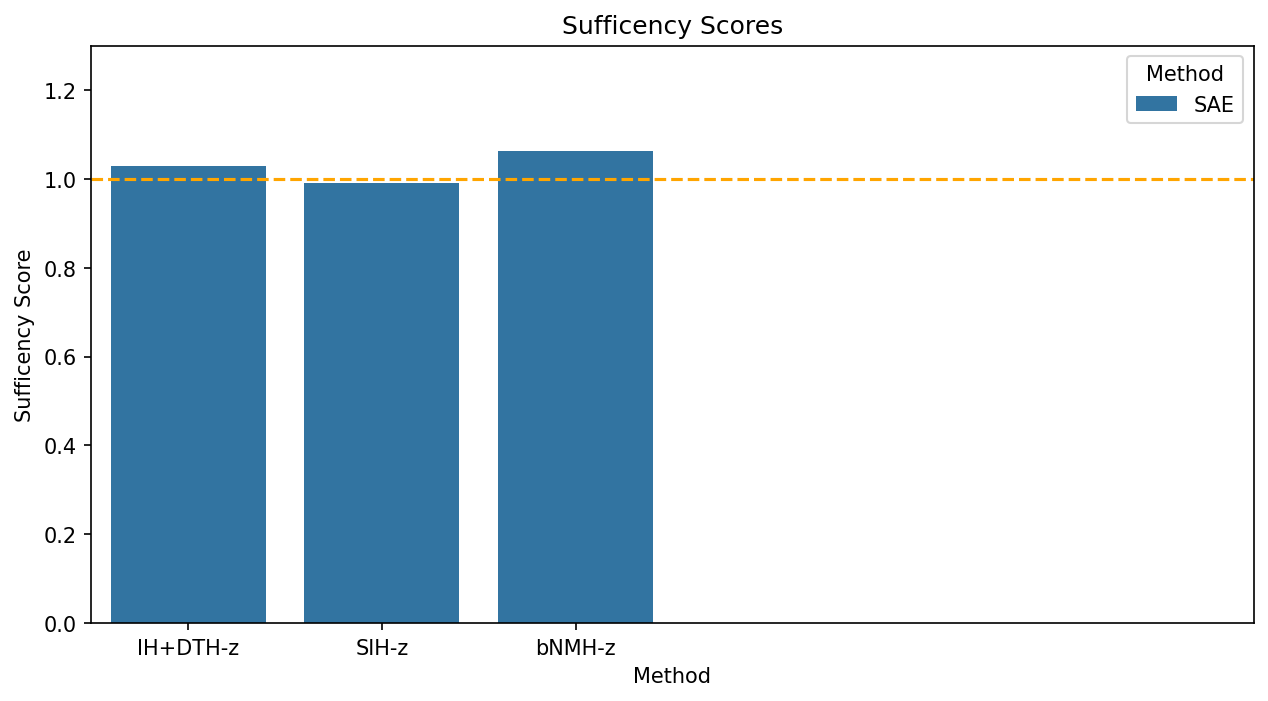

In [42]:
scores = scores_df[['sae_score']].reset_index()
scores.columns = ['Node', 'SAE']

plt.figure(figsize=(10, 5), dpi=150)
ax = sns.barplot(data=scores.melt(id_vars='Node', var_name='Method', value_name='Sufficency Score'), x='Node', y='Sufficency Score', hue='Method')
ax.set(xlabel='Method', ylabel='Sufficency Score')
plt.hlines(1, -.5, 5.5, linestyles='dashed', colors='orange')
plt.ylim(0, 1.3)
plt.xlim(-.5, 5.5)
plt.title('Sufficency Scores')
plt.show()

In [43]:
#necessity_df['supervised_diff'] = (necessity_df['ablation_ld'] - necessity_df['supervised_average_ld']).abs()
necessity_df['sae_diff'] = (necessity_df['ablation_ld'] - necessity_df['sae_average_ld']).abs()
necessity_df['ablation_diff'] = (necessity_df['ablation_ld'] - necessity_df['clean_ld']).abs()

#necessity_df['supervised_score'] = 1 - necessity_df['ablation_diff'] / necessity_df['supervised_diff']
#necessity_df['sae_score'] = 1 - necessity_df['ablation_diff'] / necessity_df['sae_diff']

In [44]:
necessity_df

,node,clean_ld,sae_average_ld,ablation_ld,sae_diff,ablation_diff
0,IH+DTH-z,3.109777,3.636126,3.428732,0.207394,0.318954
1,IH+DTH-z,4.470667,5.811017,4.997761,0.813256,0.527094
2,IH+DTH-z,4.822716,5.540103,5.413649,0.126454,0.590933
3,IH+DTH-z,1.191773,1.936498,2.021530,0.085032,0.829757
4,IH+DTH-z,1.630343,2.342978,2.333623,0.009356,0.703279
...,...,...,...,...,...,...
763,bNMH-z,5.224724,5.335290,5.577805,0.242515,0.353081
764,bNMH-z,3.740174,3.359462,3.529061,0.169600,0.211113
765,bNMH-z,2.015786,1.939881,2.020494,0.080612,0.004707
766,bNMH-z,7.053223,6.776412,6.908636,0.132224,0.144587


In [49]:
scores_df = necessity_df.groupby('node').mean()
scores_df

,clean_ld,sae_average_ld,ablation_ld,sae_diff,ablation_diff
node,,,,,
IH+DTH-z,3.674747,4.297647,4.201502,0.134652,0.528174
SIH-z,3.674747,3.804176,3.771812,0.036767,0.103747
bNMH-z,3.674747,3.631118,3.866853,0.235735,0.212113


In [46]:
#scores_df['supervised_diff'] = (scores_df['ablation_ld'] - scores_df['supervised_average_ld']).abs()
scores_df['sae_diff'] = (scores_df['ablation_ld'] - scores_df['sae_average_ld']).abs()
scores_df['ablation_diff'] = (scores_df['ablation_ld'] - scores_df['clean_ld']).abs()

In [47]:
#scores_df['supervised_score'] = 1 - scores_df['supervised_diff'] / scores_df['ablation_diff']
scores_df['sae_score'] = 1 - scores_df['sae_diff'] / scores_df['ablation_diff']

In [48]:
scores_df

,clean_ld,sae_average_ld,ablation_ld,sae_diff,ablation_diff,sae_score
node,,,,,,
IH+DTH-z,3.674747,4.297647,4.201502,0.096144,0.526755,0.817478
SIH-z,3.674747,3.804176,3.771812,0.032364,0.097065,0.666576
bNMH-z,3.674747,3.631118,3.866853,0.235735,0.192106,-0.227109


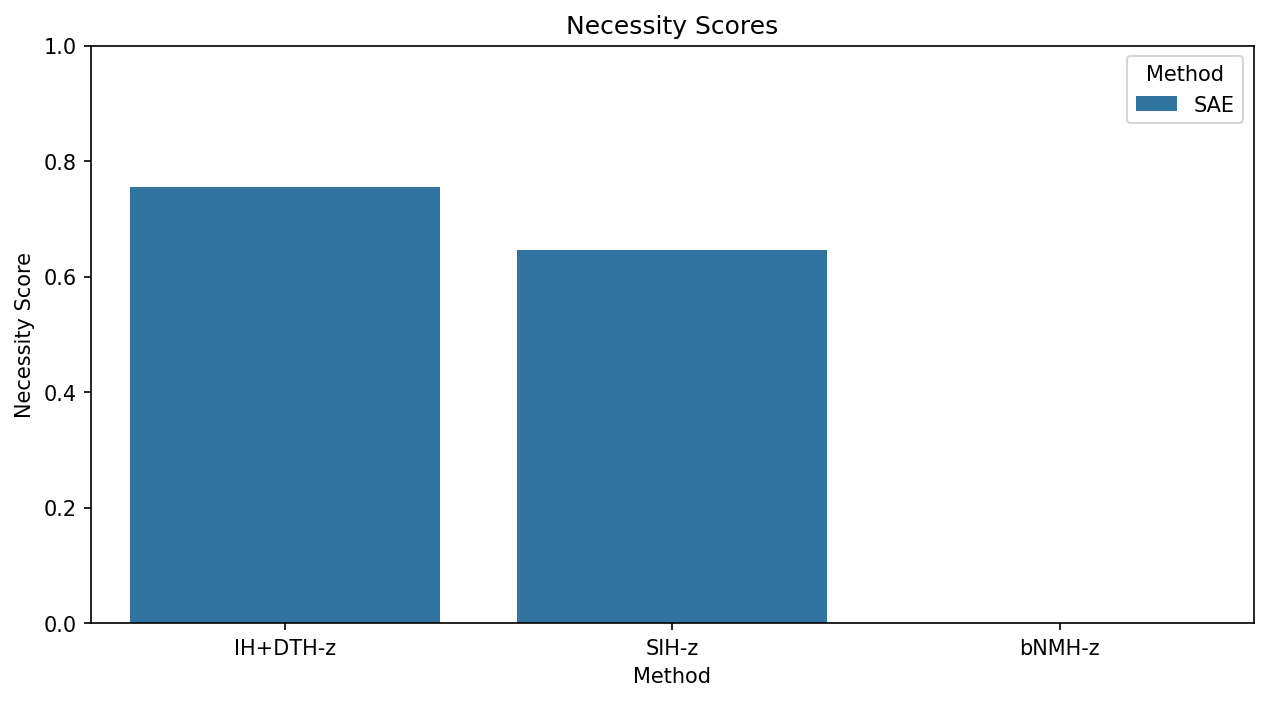

In [37]:
scores = scores_df[['sae_score']].reset_index()
scores.columns = ['Node','SAE']

plt.figure(figsize=(10, 5), dpi=150)
ax = sns.barplot(data=scores.melt(id_vars='Node', var_name='Method', value_name='Sufficency Score'), x='Node', y='Sufficency Score', hue='Method')
ax.set(xlabel='Method', ylabel='Necessity Score')
plt.ylim(0, 1)
plt.title('Necessity Scores')
plt.show()

### Sparse Controllability

In [179]:
dfs = [] 
for file in os.listdir('tasks/ioi/sc-scores/'):
    if file.endswith('.json'):
        file_name = file.split('.')[0]
        data = pd.read_json('tasks/ioi/sc-scores/' + file)
        data['node'] = file_name
        dfs.append(data)

df = pd.concat(dfs, ignore_index=True)

/var/folders/nz/t1t1ksr15lz7qypv0qvd5zyr0000gn/T/ipykernel_5063/2105426135.py:6: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0.5}` instead.

  ax = sns.barplot(data=plot_df, x='Node', y='Score', hue='Method', errwidth=0.5)


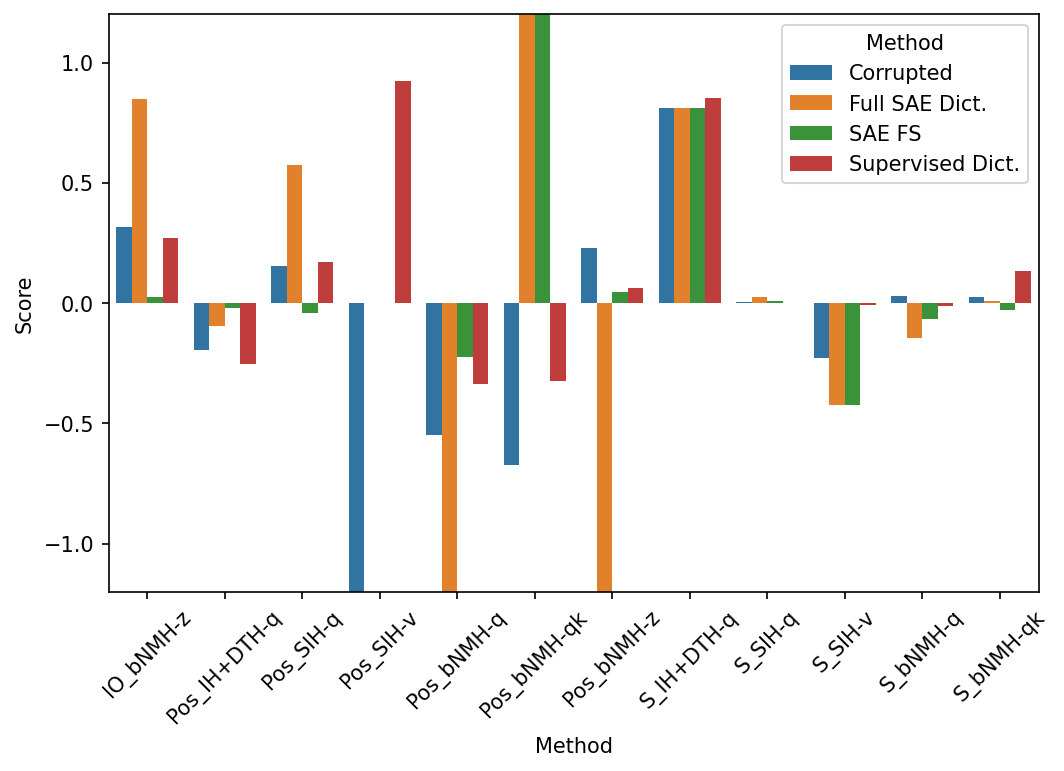

In [180]:
scores = df[['patch_corr_score', 'patch_supervised_score', 'patch_all_sae_score', 'patch_sae_fs_score', 'node']]
scores.columns = ['Corrupted', 'Supervised Dict.', 'Full SAE Dict.', 'SAE FS', 'Node']

plt.figure(figsize=(8, 5), dpi=150)
plot_df = scores.melt(id_vars='Node', var_name='Method', value_name='Score').groupby(['Node', 'Method']).mean().reset_index()
ax = sns.barplot(data=plot_df, x='Node', y='Score', hue='Method', errwidth=0.5)
ax.set_ylabel('Score')
ax.set_xlabel('Method')
plt.ylim(-1.2, 1.2)
plt.xticks(rotation=45)
plt.show()

In [231]:

# Create ldiff DataFrame
ldiff = df[['corr_ld', 'patch_corr_ld',  'patch_all_sae_ld', 'patch_sae_fs_ld', 'patch_supervised_ld', 'node']]
ldiff.columns = ['Corrupted Run', 'Patch Corrupted', 'Full SAE Dict.', 'Patch SAE FS', 'Patch Supervised Dict.', 'Node']

# Create data_subset DataFrame
data_subset = df[['clean_ld', 'node']]
data_subset.columns = ['Clean Run','Node']
print(data_subset)

# Group by Node
grouped = ldiff.groupby('Node')
data_subset_grouped = data_subset.groupby('Node')

# store results
results = {}

for node, group in grouped:
    print(f"node {node}")
    data_subset_group = data_subset_grouped.get_group(node)
    
    # Create mask for positive clean_ld values
    mask = data_subset_group['Clean Run'] > 0
    
    # Calculate threshold
    threshold = 0.05 * data_subset_group['Clean Run']
    print(threshold)
    
    # Compare each column with baseline
    for col in group.columns:
        if col != 'Node':
            agreement = (abs(group.loc[mask, col] - data_subset_group.loc[mask, 'Clean Run']) <= threshold)
            
            # Store results
            if node not in results:
                results[node] = {}
            results[node][col] = agreement.mean()

# Convert results to DataFrame for easier viewing
results_df = pd.DataFrame(results).T

print(results_df)

      Clean Run       Node
0      9.196618  IO_bNMH-z
1      8.146939  IO_bNMH-z
2      8.631424  IO_bNMH-z
3      9.004820  IO_bNMH-z
4      8.263018  IO_bNMH-z
...         ...        ...
6139   2.964078  Pos_SIH-q
6140   2.522445  Pos_SIH-q
6141   5.106237  Pos_SIH-q
6142   3.429747  Pos_SIH-q
6143   1.996371  Pos_SIH-q

[6144 rows x 2 columns]
node IO_bNMH-z
0      0.459831
1      0.407347
2      0.431571
3      0.450241
4      0.413151
         ...   
507    0.450853
508    0.322964
509    0.300397
510    0.435267
511    0.300499
Name: Clean Run, Length: 512, dtype: float64
node Pos_IH+DTH-q
4096    0.123935
4097    0.138228
4098    0.261953
4099    0.119258
4100    0.228771
          ...   
4603    0.148204
4604    0.126122
4605    0.255312
4606    0.171487
4607    0.099819
Name: Clean Run, Length: 512, dtype: float64
node Pos_SIH-q
5632    0.123935
5633    0.138228
5634    0.261953
5635    0.119258
5636    0.228771
          ...   
6139    0.148204
6140    0.126122
6141    0.2553

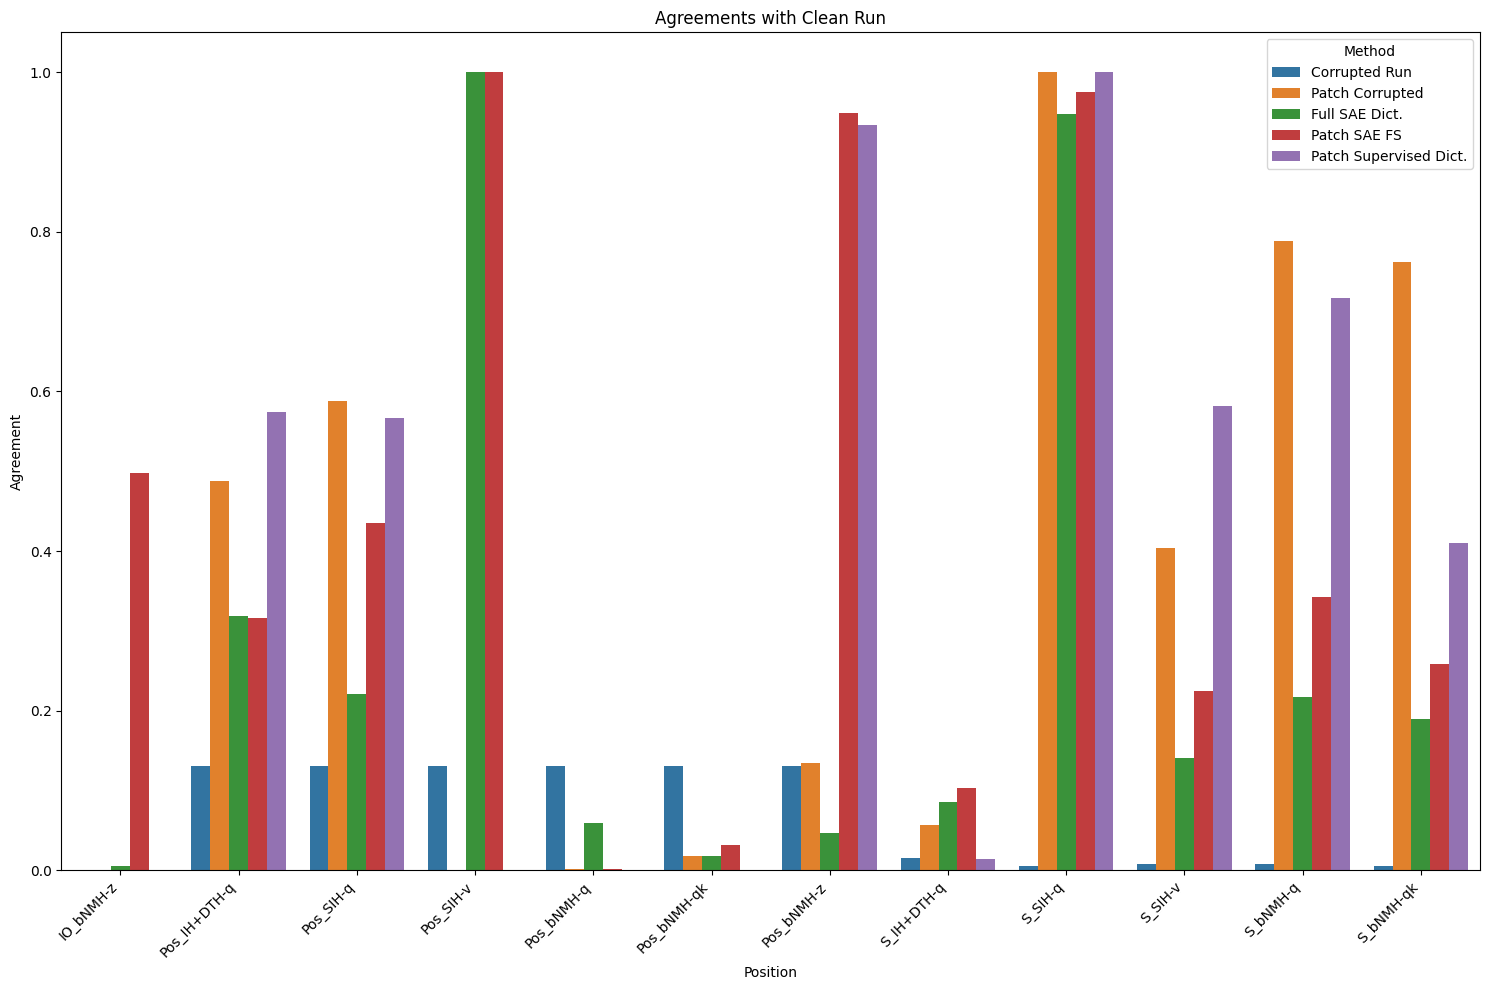

In [235]:
# Reset index to turn the index into a column
results_df_reset = results_df.reset_index()
results_df_reset = results_df_reset.rename(columns={'index': 'Position'})

# Melt the DataFrame to long format
df_melted = results_df_reset.melt(id_vars='Position', var_name='Method', value_name='Agreement')

# Create the plot
plt.figure(figsize=(15, 10))
plt.title("Agreements with Clean Run")
sns.barplot(x='Position', y='Agreement', hue='Method', data=df_melted)

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Adjust the subplot layout
plt.tight_layout()

# Show the plot
plt.show()


In [234]:
# Create ldiff DataFrame
print(df)
ldiff = df[['clean_ld', 'patch_corr_ld', 'patch_all_sae_ld', 'patch_sae_fs_ld', 'patch_supervised_ld', 'node']]
ldiff.columns = ['Clean Run', 'Patch Corrupted', 'Full SAE Dict.', 'Patch SAE FS', 'Patch Supervised Dict.', 'Node']

# Create data_subset DataFrame
data_subset = df[['corr_ld', 'node']]
data_subset.columns = ['Corrupted Run','Node']

# Group by Node
grouped = ldiff.groupby('Node')
data_subset_grouped = data_subset.groupby('Node')

# store results
results = {}

for node, group in grouped:
    print(f"node {node}")
    data_subset_group = data_subset_grouped.get_group(node)
    
    # Create mask for positive clean_ld values
    mask = data_subset_group['Corrupted Run'] > 0
    
    # Calculate threshold
    threshold = 0.1 * data_subset_group['Corrupted Run']
    print(abs(threshold))
    
    # Compare each column with baseline
    for col in group.columns:
        if col != 'Node':
            agreement = (abs(group.loc[mask, col] - data_subset_group.loc[mask, 'Corrupted Run']) <= threshold)
            
            # Store results
            if node not in results:
                results[node] = {}
            results[node][col] = agreement.mean()

# Convert results to DataFrame for easier viewing
results_df = pd.DataFrame(results).T

print(results_df)

      clean_ld   corr_ld  patch_corr_ld  patch_corr_score  \
0     9.196618 -4.925656       5.521699          0.260221   
1     8.146939 -5.530145       4.574584          0.261193   
2     8.631424 -5.516353       4.202795          0.313026   
3     9.004820 -5.921615       4.615408          0.294070   
4     8.263018 -7.325390       3.888163          0.280648   
...        ...       ...            ...               ...   
6139  2.964078  3.453401       3.058450          0.192862   
6140  2.522445  4.761069       2.716519          0.086694   
6141  5.106237  4.591607       5.182491         -0.148172   
6142  3.429747  4.738379       3.874735          0.340041   
6143  1.996371  1.022360       2.199205         -0.208246   

      patch_supervised_ld  patch_supervised_score  patch_all_sae_ld  \
0                6.258638                0.208039        -11.104477   
1                4.593412                0.259816          4.038558   
2                5.186555                0.243492     

ValueError: Can only compare identically-labeled Series objects

In [ ]:
plt.figure(figsize=(10, 5), dpi=150)
sns.barplot((1-ldiff < 0).mean())
plt.title('Agreements with corrupted run')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

ldiff_dist = np.array((1-ldiff["Full SAE Dict."] < 0))
indices = np.where(ldiff_dist == 0)
print(f"Agreement Histogram for Full SAE Dict {indices[0]}")

fig, ax = plt.subplots(figsize=(12, 4))
ax.bar(range(512), ldiff_dist.flatten(), width=1, edgecolor='black', linewidth=0.5)
ax.set(xlabel='Column Index', xticks=range(0, 512, 32), xticklabels=range(0, 512, 32), 
       ylabel='Binary Value', ylim=(0, 1), title='Distribution of 0\'s Across 512 Columns')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## TRANSFER

### Sufficency / Necessity

In [15]:
dfs = [] 

path = 'tasks/ioi/sn-scores-transfer/'

for file in os.listdir(path):
    if file.endswith('.json'):
        file_name = file.split('.')[0]
        data = pd.read_json(os.path.join(path, file))
        data['node'] = file_name
        dfs.append(data)

df = pd.concat(dfs, ignore_index=True)

In [16]:
sufficency_df = df[['node', 'clean_ld', 'sae_full_ld']].copy()
necessity_df = df[['node', 'clean_ld', 'sae_average_ld', 'ablation_ld']].copy()

In [17]:
sufficency_df['sae_diff'] = sufficency_df['clean_ld'] - sufficency_df['sae_full_ld']

In [18]:
scores_df = sufficency_df.groupby('node').mean()

scores_df['sae_score'] = 1 - scores_df['sae_diff'] / scores_df['clean_ld']

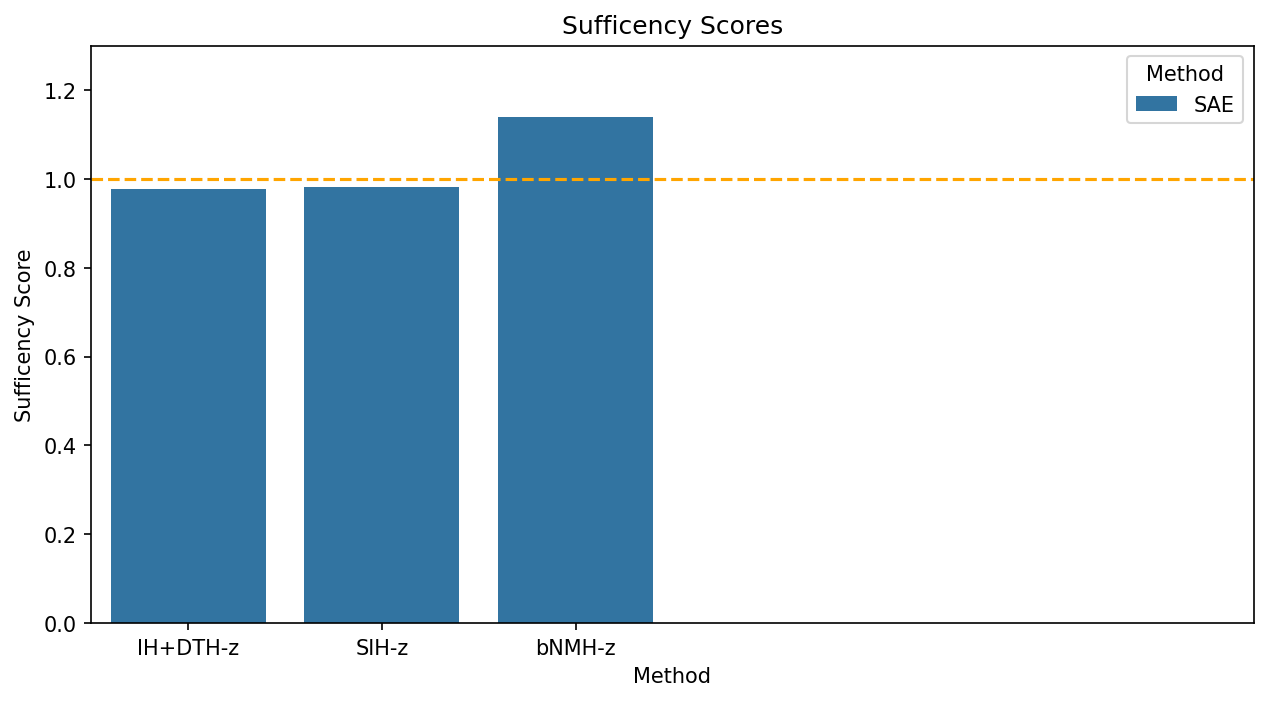

In [19]:
scores = scores_df[['sae_score']].reset_index()
scores.columns = ['Node', 'SAE']

plt.figure(figsize=(10, 5), dpi=150)
ax = sns.barplot(data=scores.melt(id_vars='Node', var_name='Method', value_name='Sufficency Score'), x='Node', y='Sufficency Score', hue='Method')
ax.set(xlabel='Method', ylabel='Sufficency Score')
plt.hlines(1, -.5, 5.5, linestyles='dashed', colors='orange')
plt.ylim(0, 1.3)
plt.xlim(-.5, 5.5)
plt.title('Sufficency Scores')
plt.show()

In [ ]:
necessity_df['supervised_diff'] = (necessity_df['ablation_ld'] - necessity_df['supervised_average_ld']).abs()
necessity_df['sae_diff'] = (necessity_df['ablation_ld'] - necessity_df['sae_average_ld']).abs()
necessity_df['ablation_diff'] = (necessity_df['ablation_ld'] - necessity_df['clean_ld']).abs()

#necessity_df['supervised_score'] = 1 - necessity_df['ablation_diff'] / necessity_df['supervised_diff']
#necessity_df['sae_score'] = 1 - necessity_df['ablation_diff'] / necessity_df['sae_diff']

In [ ]:
necessity_df

,node,clean_ld,supervised_average_ld,sae_average_ld,ablation_ld,supervised_diff,sae_diff,ablation_diff
0,bNMH-q,3.109787,-1.895371,3.046062,4.258627,6.153998,1.212564,1.148840
1,bNMH-q,4.470670,-6.896607,7.268028,4.725918,11.622525,2.542110,0.255248
2,bNMH-q,4.822708,-5.281319,5.813770,2.327124,7.608442,3.486647,2.495584
3,bNMH-q,1.191774,-7.624313,0.896391,2.020510,9.644823,1.124119,0.828735
4,bNMH-q,1.630346,-8.478821,2.636639,1.201948,9.680769,1.434690,0.428398
...,...,...,...,...,...,...,...,...
379,bNMH-z,5.345461,6.341848,6.031841,5.560406,0.781443,0.471436,0.214945
380,bNMH-z,3.184788,1.768736,4.415056,3.636469,1.867733,0.778587,0.451681
381,bNMH-z,5.286511,7.636306,6.363656,5.882052,1.754253,0.481604,0.595541
382,bNMH-z,4.801923,1.707466,5.502106,4.863420,3.155953,0.638686,0.061497


In [ ]:
scores_df = necessity_df.groupby('node').mean()
scores_df

,clean_ld,supervised_average_ld,sae_average_ld,ablation_ld,supervised_diff,sae_diff,ablation_diff
node,,,,,,,
IH+DTH-z,3.412866,4.371753,1.850468,3.900634,1.509149,2.172814,0.510126
SIH-v,3.412866,-10.970300,1.896267,1.486897,12.457197,0.414295,1.925968
SIH-z,3.412866,2.723090,3.608531,3.502308,0.841089,0.123829,0.096357
bNMH-q,3.412866,-5.828867,3.800605,3.493995,9.322862,0.967229,1.003486
bNMH-qk,3.412866,14.776601,3.902067,3.048507,11.728094,1.147696,0.806222
bNMH-z,3.412866,3.173731,4.369481,3.593172,2.012494,0.868807,0.199984


In [ ]:
scores_df['supervised_diff'] = (scores_df['ablation_ld'] - scores_df['supervised_average_ld']).abs()
scores_df['sae_diff'] = (scores_df['ablation_ld'] - scores_df['sae_average_ld']).abs()
scores_df['ablation_diff'] = (scores_df['ablation_ld'] - scores_df['clean_ld']).abs()

In [ ]:
scores_df['supervised_score'] = 1 - scores_df['supervised_diff'] / scores_df['ablation_diff']
scores_df['sae_score'] = 1 - scores_df['sae_diff'] / scores_df['ablation_diff']

In [ ]:
scores_df

,clean_ld,supervised_average_ld,sae_average_ld,ablation_ld,supervised_diff,sae_diff,ablation_diff,supervised_score,sae_score
node,,,,,,,,,
IH+DTH-z,3.412866,4.371753,1.850468,3.900634,0.471119,2.050167,0.487769,0.034134,-3.203155
SIH-v,3.412866,-10.970300,1.896267,1.486897,12.457197,0.409370,1.925968,-5.468018,0.787447
SIH-z,3.412866,2.723090,3.608531,3.502308,0.779219,0.106223,0.089442,-7.711965,-0.187617
bNMH-q,3.412866,-5.828867,3.800605,3.493995,9.322862,0.306610,0.081129,-113.913735,-2.779276
bNMH-qk,3.412866,14.776601,3.902067,3.048507,11.728094,0.853560,0.364359,-31.188289,-1.342635
bNMH-z,3.412866,3.173731,4.369481,3.593172,0.419441,0.776309,0.180306,-1.326266,-3.305498


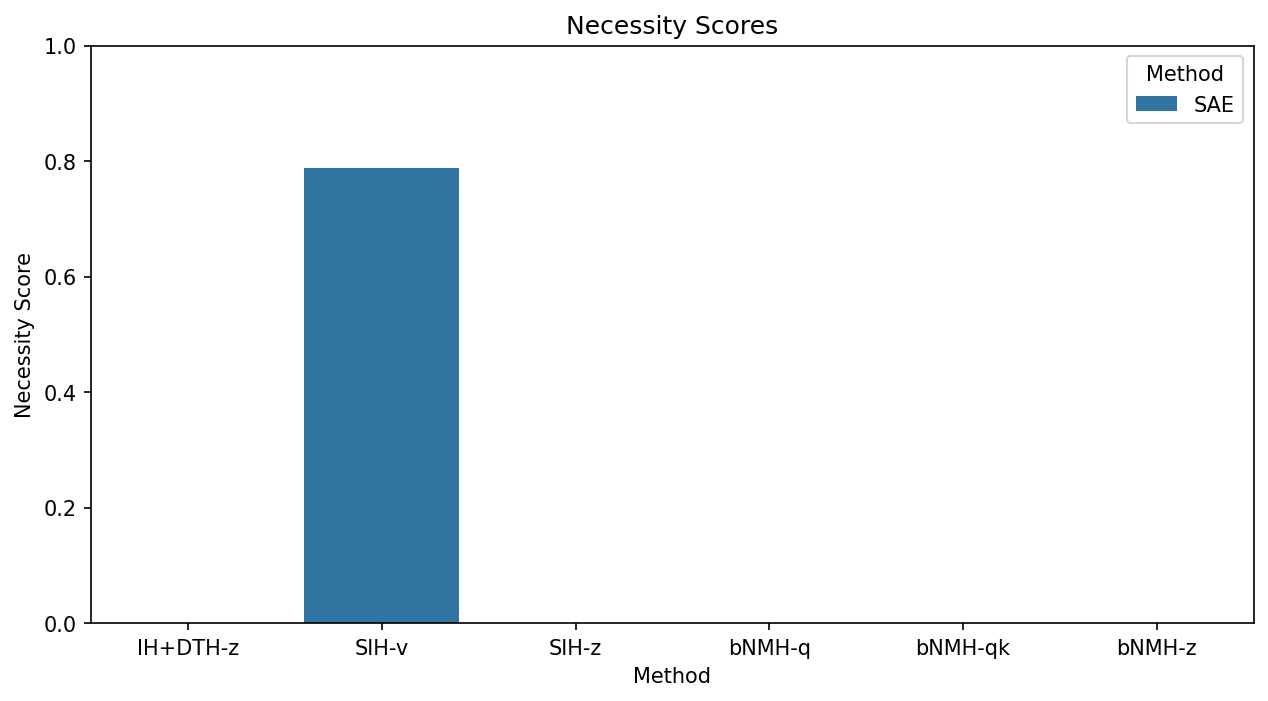

In [ ]:
scores = scores_df[['sae_score']].reset_index()
scores.columns = ['Node','SAE']

plt.figure(figsize=(10, 5), dpi=150)
ax = sns.barplot(data=scores.melt(id_vars='Node', var_name='Method', value_name='Sufficency Score'), x='Node', y='Sufficency Score', hue='Method')
ax.set(xlabel='Method', ylabel='Necessity Score')
plt.ylim(0, 1)
plt.title('Necessity Scores')
plt.show()

### Sparse Controllability

In [ ]:
dfs = [] 
for file in os.listdir('tasks/ioi/sc-scores/'):
    if file.endswith('.json'):
        file_name = file.split('.')[0]
        data = pd.read_json('tasks/ioi/sc-scores/' + file)
        data['node'] = file_name
        dfs.append(data)

df = pd.concat(dfs, ignore_index=True)

/var/folders/nz/t1t1ksr15lz7qypv0qvd5zyr0000gn/T/ipykernel_5063/2105426135.py:6: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0.5}` instead.

  ax = sns.barplot(data=plot_df, x='Node', y='Score', hue='Method', errwidth=0.5)


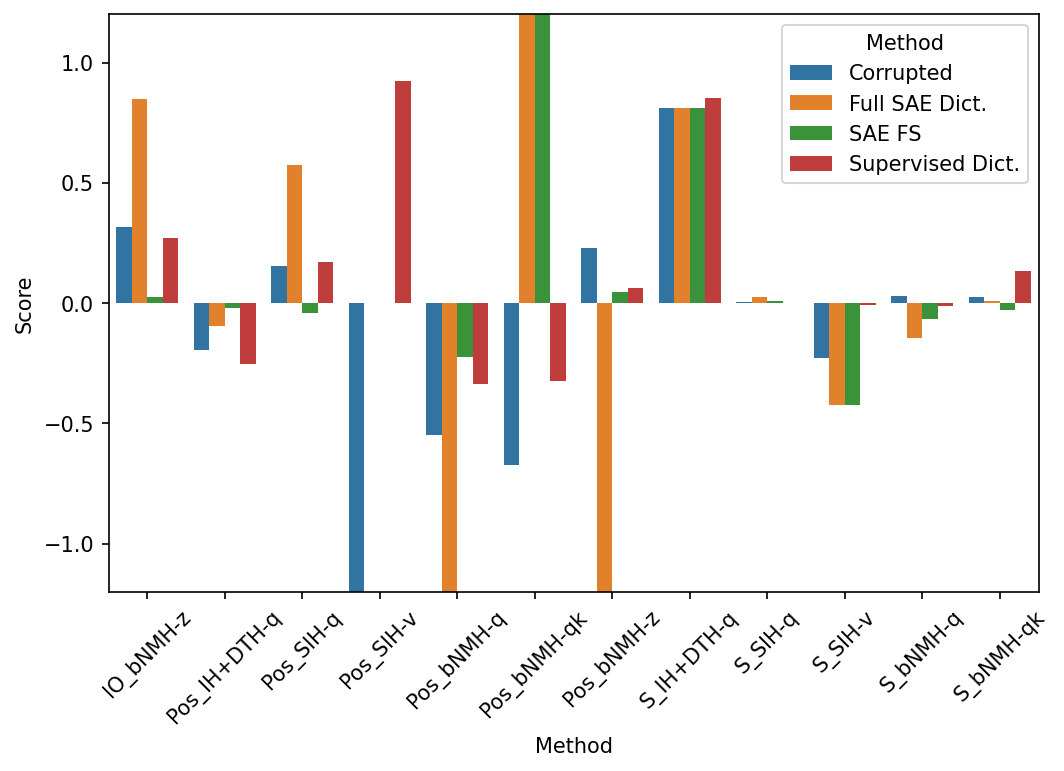

In [ ]:
scores = df[['patch_corr_score', 'patch_supervised_score', 'patch_all_sae_score', 'patch_sae_fs_score', 'node']]
scores.columns = ['Corrupted', 'Supervised Dict.', 'Full SAE Dict.', 'SAE FS', 'Node']

plt.figure(figsize=(8, 5), dpi=150)
plot_df = scores.melt(id_vars='Node', var_name='Method', value_name='Score').groupby(['Node', 'Method']).mean().reset_index()
ax = sns.barplot(data=plot_df, x='Node', y='Score', hue='Method', errwidth=0.5)
ax.set_ylabel('Score')
ax.set_xlabel('Method')
plt.ylim(-1.2, 1.2)
plt.xticks(rotation=45)
plt.show()

In [ ]:

# Create ldiff DataFrame
ldiff = df[['corr_ld', 'patch_corr_ld',  'patch_all_sae_ld', 'patch_sae_fs_ld', 'patch_supervised_ld', 'node']]
ldiff.columns = ['Corrupted Run', 'Patch Corrupted', 'Full SAE Dict.', 'Patch SAE FS', 'Patch Supervised Dict.', 'Node']

# Create data_subset DataFrame
data_subset = df[['clean_ld', 'node']]
data_subset.columns = ['Clean Run','Node']
print(data_subset)

# Group by Node
grouped = ldiff.groupby('Node')
data_subset_grouped = data_subset.groupby('Node')

# store results
results = {}

for node, group in grouped:
    print(f"node {node}")
    data_subset_group = data_subset_grouped.get_group(node)
    
    # Create mask for positive clean_ld values
    mask = data_subset_group['Clean Run'] > 0
    
    # Calculate threshold
    threshold = 0.05 * data_subset_group['Clean Run']
    print(threshold)
    
    # Compare each column with baseline
    for col in group.columns:
        if col != 'Node':
            agreement = (abs(group.loc[mask, col] - data_subset_group.loc[mask, 'Clean Run']) <= threshold)
            
            # Store results
            if node not in results:
                results[node] = {}
            results[node][col] = agreement.mean()

# Convert results to DataFrame for easier viewing
results_df = pd.DataFrame(results).T

print(results_df)

      Clean Run       Node
0      9.196618  IO_bNMH-z
1      8.146939  IO_bNMH-z
2      8.631424  IO_bNMH-z
3      9.004820  IO_bNMH-z
4      8.263018  IO_bNMH-z
...         ...        ...
6139   2.964078  Pos_SIH-q
6140   2.522445  Pos_SIH-q
6141   5.106237  Pos_SIH-q
6142   3.429747  Pos_SIH-q
6143   1.996371  Pos_SIH-q

[6144 rows x 2 columns]
node IO_bNMH-z
0      0.459831
1      0.407347
2      0.431571
3      0.450241
4      0.413151
         ...   
507    0.450853
508    0.322964
509    0.300397
510    0.435267
511    0.300499
Name: Clean Run, Length: 512, dtype: float64
node Pos_IH+DTH-q
4096    0.123935
4097    0.138228
4098    0.261953
4099    0.119258
4100    0.228771
          ...   
4603    0.148204
4604    0.126122
4605    0.255312
4606    0.171487
4607    0.099819
Name: Clean Run, Length: 512, dtype: float64
node Pos_SIH-q
5632    0.123935
5633    0.138228
5634    0.261953
5635    0.119258
5636    0.228771
          ...   
6139    0.148204
6140    0.126122
6141    0.2553

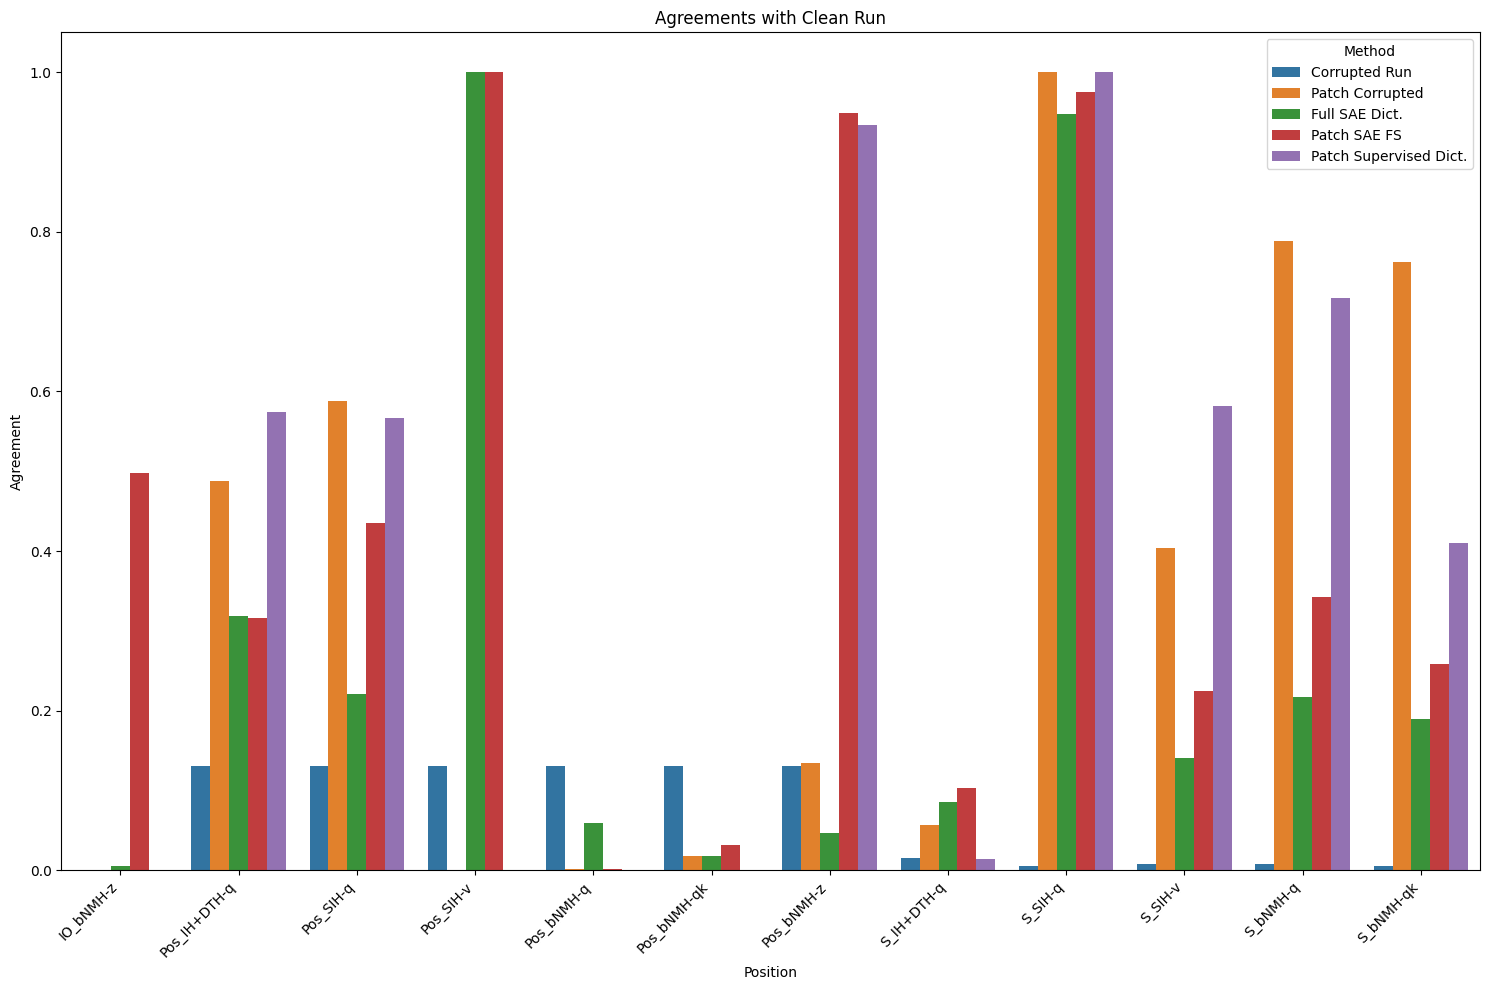

In [ ]:
# Reset index to turn the index into a column
results_df_reset = results_df.reset_index()
results_df_reset = results_df_reset.rename(columns={'index': 'Position'})

# Melt the DataFrame to long format
df_melted = results_df_reset.melt(id_vars='Position', var_name='Method', value_name='Agreement')

# Create the plot
plt.figure(figsize=(15, 10))
plt.title("Agreements with Clean Run")
sns.barplot(x='Position', y='Agreement', hue='Method', data=df_melted)

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Adjust the subplot layout
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
# Create ldiff DataFrame
print(df)
ldiff = df[['clean_ld', 'patch_corr_ld', 'patch_all_sae_ld', 'patch_sae_fs_ld', 'patch_supervised_ld', 'node']]
ldiff.columns = ['Clean Run', 'Patch Corrupted', 'Full SAE Dict.', 'Patch SAE FS', 'Patch Supervised Dict.', 'Node']

# Create data_subset DataFrame
data_subset = df[['corr_ld', 'node']]
data_subset.columns = ['Corrupted Run','Node']

# Group by Node
grouped = ldiff.groupby('Node')
data_subset_grouped = data_subset.groupby('Node')

# store results
results = {}

for node, group in grouped:
    print(f"node {node}")
    data_subset_group = data_subset_grouped.get_group(node)
    
    # Create mask for positive clean_ld values
    mask = data_subset_group['Corrupted Run'] > 0
    
    # Calculate threshold
    threshold = 0.1 * data_subset_group['Corrupted Run']
    print(abs(threshold))
    
    # Compare each column with baseline
    for col in group.columns:
        if col != 'Node':
            agreement = (abs(group.loc[mask, col] - data_subset_group.loc[mask, 'Corrupted Run']) <= threshold)
            
            # Store results
            if node not in results:
                results[node] = {}
            results[node][col] = agreement.mean()

# Convert results to DataFrame for easier viewing
results_df = pd.DataFrame(results).T

print(results_df)

      clean_ld   corr_ld  patch_corr_ld  patch_corr_score  \
0     9.196618 -4.925656       5.521699          0.260221   
1     8.146939 -5.530145       4.574584          0.261193   
2     8.631424 -5.516353       4.202795          0.313026   
3     9.004820 -5.921615       4.615408          0.294070   
4     8.263018 -7.325390       3.888163          0.280648   
...        ...       ...            ...               ...   
6139  2.964078  3.453401       3.058450          0.192862   
6140  2.522445  4.761069       2.716519          0.086694   
6141  5.106237  4.591607       5.182491         -0.148172   
6142  3.429747  4.738379       3.874735          0.340041   
6143  1.996371  1.022360       2.199205         -0.208246   

      patch_supervised_ld  patch_supervised_score  patch_all_sae_ld  \
0                6.258638                0.208039        -11.104477   
1                4.593412                0.259816          4.038558   
2                5.186555                0.243492     

ValueError: Can only compare identically-labeled Series objects

In [ ]:
plt.figure(figsize=(10, 5), dpi=150)
sns.barplot((1-ldiff < 0).mean())
plt.title('Agreements with corrupted run')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

ldiff_dist = np.array((1-ldiff["Full SAE Dict."] < 0))
indices = np.where(ldiff_dist == 0)
print(f"Agreement Histogram for Full SAE Dict {indices[0]}")

fig, ax = plt.subplots(figsize=(12, 4))
ax.bar(range(512), ldiff_dist.flatten(), width=1, edgecolor='black', linewidth=0.5)
ax.set(xlabel='Column Index', xticks=range(0, 512, 32), xticklabels=range(0, 512, 32), 
       ylabel='Binary Value', ylim=(0, 1), title='Distribution of 0\'s Across 512 Columns')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
